In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("dada2", version = "3.18")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org



Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)



Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'dada2'”


Old packages: 'Biobase', 'BiocGenerics', 'BiocManager', 'BiocParallel',
  'Biostrings', 'DelayedArray', 'evaluate', 'gargle', 'GenomeInfoDb',
  'GenomicAlignments', 'GenomicRanges', 'googlesheets4', 'IRanges',
  'MatrixGenerics', 'ragg', 'RcppParallel', 'Rhtslib', 'Rsamtools', 'rvest',
  'S4Arrays', 'S4Vectors', 'ShortRead', 'stringr', 'SummarizedExperiment',
  'textshaping', 'XVector', 'zlibbioc'



In [2]:
#load libraries
require(tidyr)
require(dplyr)
require(reshape2)
require(ggplot2)
library("dada2")

Loading required package: tidyr



Loading required package: dplyr




Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Loading required package: reshape2




Attaching package: ‘reshape2’




The following object is masked from ‘package:tidyr’:

    smiths




Loading required package: ggplot2



Loading required package: Rcpp



In [3]:
# load working pcr csv
pcr=read.csv("/home/caroline_desouza_uml_edu/2_randomized_immune_metagenomics_PCR.csv")

In [4]:
head(pcr)

,X,Tubelabel_species,Health_Status,Date_Extracted,Raw_ng_ul,Extraction_physical_location,Date_Enriched,Microbe_Location,colony,Date_16S,Date_ITS2,X16S.double.band
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,052022_BEL_CBC_T1_2_SSID,Healthy,12_2_2024,7.73,"UML_NARWHAL_R2_B14, UML_NARWHAL_R2_B33",,,1_3,1_22_2025,6_26_2025,
2,2,092023_BEL_CBC_T1_175_PAST,Healthy,1_15_2025,2.3,UML_NARWHAL_R2_B15,,,1_13,1_22_2025,6_26_2025,y
3,3,092023_BEL_CBC_T1_175_PAST,Healthy,11_8_2024,0.14,UML_NARWHAL_R2_B12,,,1_13,1_22_2025,6_26_2025,y
4,4,022024_BEL_CBC_T3_851_PSTR,Healthy,11_26_2024,64.2,UML_NARWHAL_R2_B13,,,3_70,1_23_2025,6_26_2025,
5,5,082024_BEL_CBC_T4_1609_OFAV,Healthy,1_15_2025,61.2,UML_NARWHAL_R2_B15,,,4_78,1_23_2025,6_26_2025,y
6,6,122023_BEL_CBC_T3_526_SSID,Healthy,11_19_2024,16.4,UML_NARWHAL_R2_B13,,,3_5,1_23_2025,6_26_2025,


In [5]:
#isolate samples that have been through 16S pcr
pcr <- pcr %>%
  filter(!is.na(Date_16S) & Date_16S != "NA")

In [6]:
#new col where double is in binary code
pcr <- pcr %>%
  mutate(double = ifelse(X16S.double.band == "y", 1, 0))

In [7]:
pcr_clean = pcr[c("Tubelabel_species", "double")]

In [8]:
head(pcr_clean)

,Tubelabel_species,double
,<chr>,<dbl>
1,052022_BEL_CBC_T1_2_SSID,0
2,092023_BEL_CBC_T1_175_PAST,1
3,092023_BEL_CBC_T1_175_PAST,1
4,022024_BEL_CBC_T3_851_PSTR,0
5,082024_BEL_CBC_T4_1609_OFAV,1
6,122023_BEL_CBC_T3_526_SSID,0


In [9]:
#load 16S sequences
path="/scratch3/workspace/caroline_desouza_uml_edu-CBC_immune_microbe/split_reads/16S"

In [10]:
#running dada2 on 16S sequences
fnFs = sort(list.files(path, pattern="_R1_16S.fastq", full.names = TRUE))
fnRs = sort(list.files(path, pattern="_R2_16S.fastq", full.names = TRUE))

In [11]:
sample.names = sapply(strsplit(basename(fnFs), "_"), `[`, 1)

Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_tile()`).”


Warning message:
“Removed 44 rows containing missing values or values outside the scale range
(`geom_tile()`).”


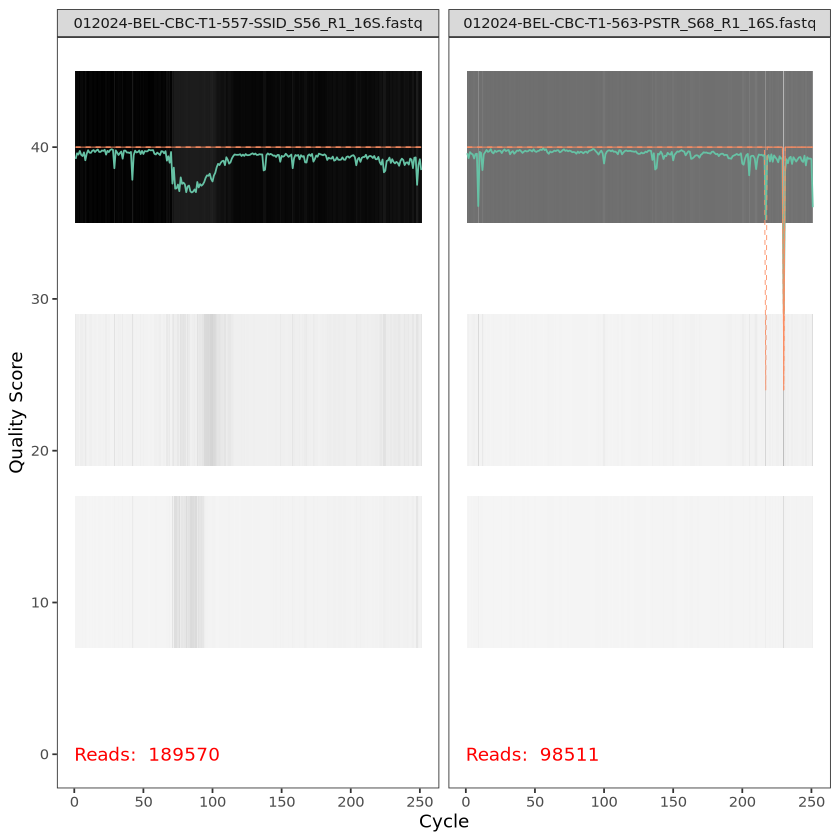

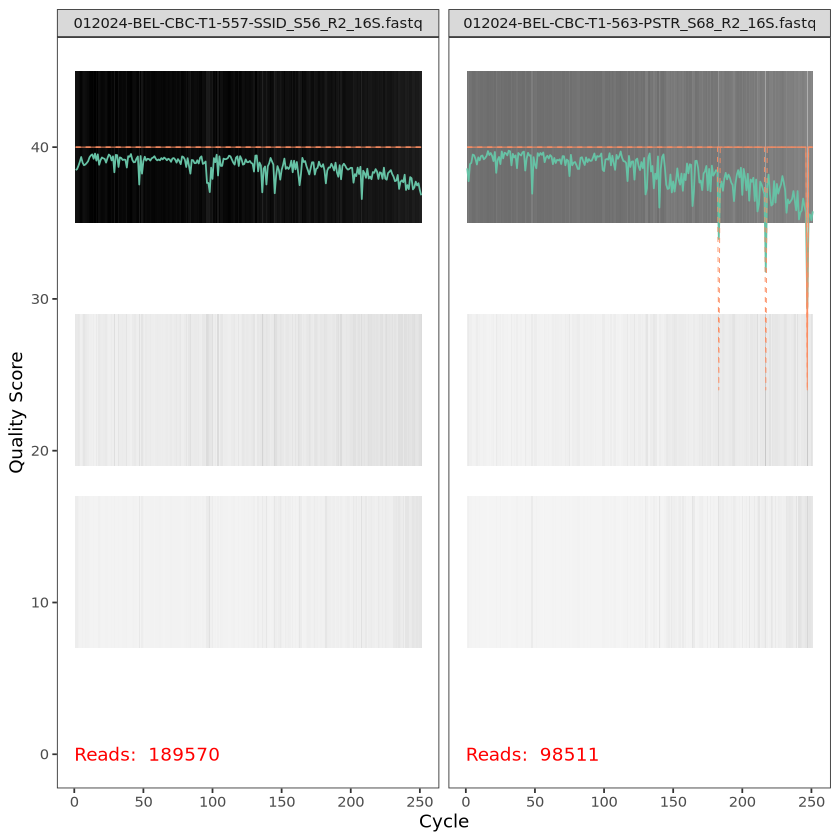

In [12]:
# quality profiles for R1 and R2
plotQualityProfile(fnFs[1:2])
plotQualityProfile(fnRs[1:2])

In [13]:
#set up where the filtered outputs will be stored
filtFs = file.path(path, "filtered", paste0(sample.names, "_F_16S_filt.fastq.gz"))
filtRs = file.path(path, "filtered", paste0(sample.names, "_R_16S_filt.fastq.gz"))
names(filtFs) = sample.names
names(filtRs) = sample.names

In [14]:
# actually filtering and trimming sequences
# if too few reads passing the filter consider relaxing maxEE
out <- filterAndTrim(fnFs, filtFs, fnRs, filtRs, truncLen=c(250,230),
              maxN=0, maxEE=c(2,2), truncQ=2, rm.phix=TRUE,
              compress=TRUE, multithread=TRUE, verbose=TRUE) # On Windows set multithread=FALSE
print(out)

                                             reads.in reads.out
012024-BEL-CBC-T1-557-SSID_S56_R1_16S.fastq    189570    175359
012024-BEL-CBC-T1-563-PSTR_S68_R1_16S.fastq     98511     89002
012024-BEL-CBC-T2-601-OFAV_S58_R1_16S.fastq    280308    263276
012024-BEL-CBC-T2-605-SSID_S83_R1_16S.fastq      1116       924
012024-BEL-CBC-T3-627-PAST_S81_R1_16S.fastq      6549      5112
012024-BEL-CBC-T3-631-MCAV_S61_R1_16S.fastq    536790    494756
012024-BEL-CBC-T3-633-MCAV_S69_R1_16S.fastq    163169    154646
012024-BEL-CBC-T3-637-SSID_S70_R1_16S.fastq     22749     21087
012024-BEL-CBC-T4-661-PSTR_S71_R1_16S.fastq    464328    425153
012024-BEL-CBC-T4-663-PSTR_S82_R1_16S.fastq      1295      1039
022024-BEL-CBC-T1-775-OANN_S93_R1_16S.fastq      2146      1732
022024-BEL-CBC-T1-776-PSTR_S59_R1_16S.fastq    115016    104031
022024-BEL-CBC-T2-804-OFAV_S87_R1_16S.fastq      5900      4830
022024-BEL-CBC-T2-814-MCAV_S1_R1_16S.fastq       3376      2794
022024-BEL-CBC-T3-851-PSTR_S13_R1_16S.fa

In [15]:
#make a file of the outputs of 16S reads with tube label species
write.csv(out, file="/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/outputs/16Sreads.csv")

In [16]:
#use this file to add columns to pcr_split
reads=read.csv("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/outputs/16Sreads.csv")

In [17]:
#change format of tubelabel_species exactly match pcr_clean 
# Extract and reformat filename to "Tubelabel_species"
reads <- reads %>%
  mutate(
    Tubelabel_species = gsub("-", "_", sub("(_S\\d+_R\\d+_16S\\.fastq)$", "", X))
  )

#no need to use old sequence file column
reads = reads[c("reads.in", "reads.out", "Tubelabel_species")]
# View the new data frame
head(reads)

,reads.in,reads.out,Tubelabel_species
,<int>,<int>,<chr>
1,189570,175359,012024_BEL_CBC_T1_557_SSID
2,98511,89002,012024_BEL_CBC_T1_563_PSTR
3,280308,263276,012024_BEL_CBC_T2_601_OFAV
4,1116,924,012024_BEL_CBC_T2_605_SSID
5,6549,5112,012024_BEL_CBC_T3_627_PAST
6,536790,494756,012024_BEL_CBC_T3_631_MCAV


In [18]:
# inner join 
reads_doubleband <- merge(x=pcr_clean,y=reads, 
                by="Tubelabel_species")
head(reads_doubleband)

,Tubelabel_species,double,reads.in,reads.out
,<chr>,<dbl>,<int>,<int>
1,012024_BEL_CBC_T1_557_SSID,1,189570,175359
2,012024_BEL_CBC_T1_563_PSTR,0,98511,89002
3,012024_BEL_CBC_T2_601_OFAV,0,280308,263276
4,012024_BEL_CBC_T2_605_SSID,1,1116,924
5,012024_BEL_CBC_T3_627_PAST,1,6549,5112
6,012024_BEL_CBC_T3_631_MCAV,0,536790,494756


In [19]:
#make spreadsheet with # of reads and double banding status
write.csv(reads_doubleband, file="/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/outputs/16Sreads_doubleband.csv")

In [1]:
reads_double=read.csv("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/outputs/16Sreads_doubleband.csv")

In [2]:
#new column with total number of reads
reads_double$total.reads <- reads_double$reads.in + reads_double$reads.out

In [4]:
head(reads_double)

,X,Tubelabel_species,double,reads.in,reads.out,total.reads
,<int>,<chr>,<int>,<int>,<int>,<int>
1,1,012024_BEL_CBC_T1_557_SSID,1,189570,175359,364929
2,2,012024_BEL_CBC_T1_563_PSTR,0,98511,89002,187513
3,3,012024_BEL_CBC_T2_601_OFAV,0,280308,263276,543584
4,4,012024_BEL_CBC_T2_605_SSID,1,1116,924,2040
5,5,012024_BEL_CBC_T3_627_PAST,1,6549,5112,11661
6,6,012024_BEL_CBC_T3_631_MCAV,0,536790,494756,1031546


In [5]:
require(tidyr)
require(dplyr)
require(reshape2)
require(ggplot2)

Loading required package: tidyr

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: reshape2


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: ggplot2



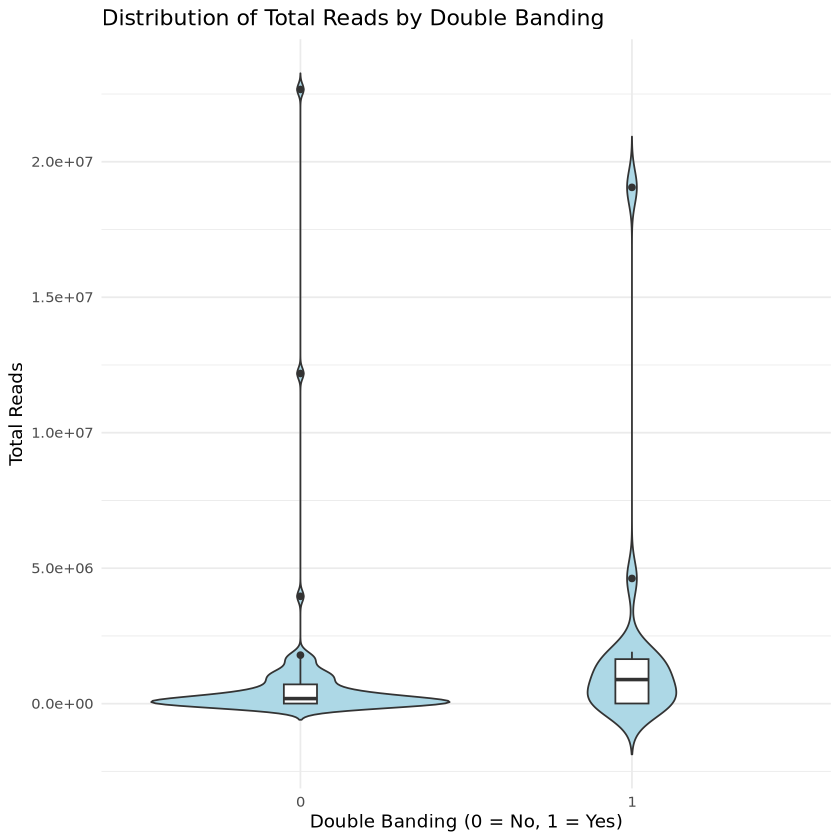

In [6]:
#using a violin plot to visualize the distribution of length of reads (y) and y or no double banding (x)
ggplot(reads_double, aes(x = factor(double), y = total.reads)) +
  geom_violin(trim = FALSE, fill = "lightblue") +
  geom_boxplot(width = 0.1) +
  labs(x = "Double Banding (0 = No, 1 = Yes)", y = "Total Reads",
       title = "Distribution of Total Reads by Double Banding") +
  theme_minimal()

In [7]:
#statistical tests

# t-test (if data is normally distributed)
t.test(total.reads ~ double, data = reads_double)

# Wilcoxon Test (more robust, my data is not normally distributed)
wilcox.test(total.reads ~ double, data = reads_double)


	Welch Two Sample t-test

data:  total.reads by double
t = -1.0375, df = 18.881, p-value = 0.3126
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -3591341  1211592
sample estimates:
mean in group 0 mean in group 1 
       853923.3       2043797.6 



	Wilcoxon rank sum test with continuity correction

data:  total.reads by double
W = 461, p-value = 0.04385
alternative hypothesis: true location shift is not equal to 0
